# Introduction to Photonic Band Gap fiber class.

The class PBG is used to create geometries describing Photonic Band Gap fibers and assist in calculating their modes.  In this tutorial we describe how to create PBG class objects for these geometries and use these objects to find the desired modes.

## Setup: Parameters

Photonic Band Gap fibers feature a hexagonal lattice of tubes of high refractive index embedded in a cladding of lower refractive index.  Below we see two examples of such fibers.  The image is taken from [1].

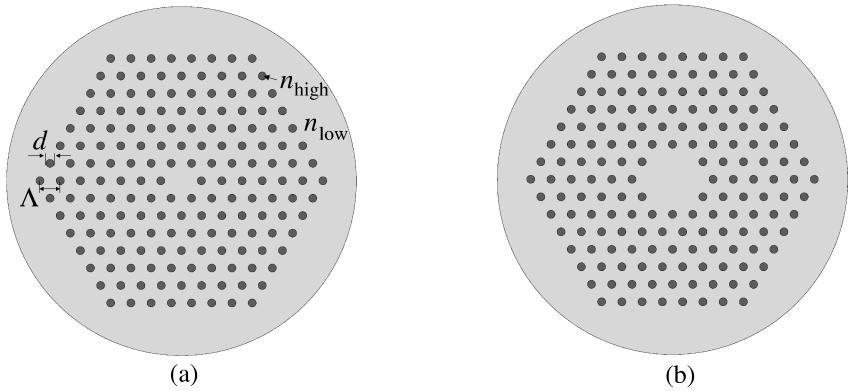

In [2]:
from IPython.display import Image
Image(filename='basic_fibers.png') 

The parameters necessary for recreating these fibers are stored in the directory "fiber_dicts" inside the main "pbg" directory.  The parameters for fiber (a) are shown below:

In [3]:
from fiberamp.fiber.microstruct.pbg.fiber_dicts.lyr7cr1 import params

params

{'p': 6,
 'layers': 7,
 'skip': 1,
 'pattern': [],
 'sep': 7e-06,
 'r': 1.4000000000000001e-06,
 'S': 6.3e-05,
 'scale': 4.48e-06,
 'n_tube': 1.48,
 'n_clad': 1.45,
 't_air': 1.4e-05,
 't_outer': 4.2e-05,
 'alpha': 5,
 'pml_maxh': 7.031249999999999,
 'air_maxh': 1.40625,
 'tube_maxh': 0.703125,
 'clad_maxh': 1.40625,
 'core_maxh': 1.125}

The meaning of these parameters is as follows:


Geometric Paramters:
- p: refers to the number of sides of the polygonal lattice.  For a hexagonal lattice we use p=6.
- layers: refers to the number of layers of tubes.  For (a) there are a total of 7 layers.
- skip: indicates number of layers of tubes to be skipped to make the core region.  For (a) we skip 1 layer, while for (b) we skip 2.
- sep: Identical to $\Lambda$ above; indicates the distance separating layers of tubes
- r: the radius of the tubes, equal to d/2 where d appears above.
- S: The radius of the fiber as a whole.
- scale: factor by which to scale the fiber parameters to make a non-dimensional geometry.  Chosen to make the core region approximately unit radius.
- n_tube, n_clad: the refractive indices of the tube and cladding material respectively.

Mesh Parameters:
- t_air, t_outer: desired thickness of air and PML regions respectively.
- alpha: PML parameter.
- pml_, air_, tube_, clad_, core_ maxh: maximum element diameter for mesh on respective regions.

If you wish to create a different fiber, copy the file and alter parameters to your liking and rename it.  Note that the name 'lyr7cr1' indicates the fiber has seven layers of tubes and a core of one missing layer of tubes.  The file containing the parameters for (b) is called 'lyr6cr2' conforming to this.

## Creating a PBG fiber instance

We can instantiate a PBG class object by loading the class and a parameter dictionary like the one described above, and passing the dictionary to the class:

In [1]:
from fiberamp.fiber.microstruct.pbg import PBG
from fiberamp.fiber.microstruct.pbg.fiber_dicts.lyr7cr1 import params

In [2]:
A = PBG(params)

ModeSolver: Checking if mesh has required regions


In [3]:
A.__dict__

{'p': 6,
 'layers': 7,
 'skip': 1,
 'pattern': [],
 'sep': 7e-06,
 'r': 1.4000000000000001e-06,
 'S': 6.3e-05,
 'scale': 4.48e-06,
 'n_tube': 1.48,
 'n_clad': 1.45,
 't_air': 1.4e-05,
 't_outer': 4.2e-05,
 'alpha': 5,
 'pml_maxh': 7.031249999999999,
 'air_maxh': 1.40625,
 'tube_maxh': 0.703125,
 'clad_maxh': 1.40625,
 'core_maxh': 1.125,
 '_wavelength': 1.8e-06,
 'k': 3490658.503988659,
 'n0': 1.00027717,
 'R0': 14.062499999999998,
 'R': 17.1875,
 'Rout': 26.562499999999996,
 'geo': <netgen.libngpy._geom2d.SplineGeometry at 0x7f40e6520590>,
 'mat': {'Outer': 4, 'air': 3, 'tube': 2, 'clad': 1, 'core': 5},
 'mesh': <ngsolve.comp.Mesh at 0x7f416faa1f90>,
 'L': 4.48e-06,
 'ngspmlset': False,
 'V': <ngsolve.fem.CoefficientFunction at 0x7f40e65205e0>}

Now we can visualize the mesh as follows:


In [4]:
import netgen.gui
import ngsolve as ng

In [5]:
ng.Draw(A.mesh)

The fiber shown in (b) is created similarly:

In [6]:
from fiberamp.fiber.microstruct.pbg.fiber_dicts.lyr6cr2 import params

In [7]:
B = PBG(params)

ModeSolver: Checking if mesh has required regions


In [8]:
ng.Draw(B.mesh)

## Mode finding

Since the PBG class is derived from ModeSolver, we can use the facilites there to look for modes of the fiber.  Doing so would look like the following:

In [10]:
z2, y2, yl2, beta2, P2, _ = A.leakymode(2, ctr=3.56545193-0.00913029j, rad=.01)

ModeSolver.leakymode called on object with these settings:
Set freq-dependent PML with p= 2  alpha= 1 and thickness=9.375

SpectralProj: Setting shifted trapezoidal rule quadrature on circular contour
SpectralProj: Radius=0.01, Center=3.56545-0.00913029j
SpectralProjNGPoly: Checking if A[d] is nonzero & Hermitian.
SpectralProjNG: Checking if inverse.H works for umfpack
SpectralProjNGPoly: Computing resolvents along the contour using
                    inverse type umfpack (installed default umfpack)
SpectralProjNGPoly: Factorizing 42846x42846 system at z =  +3.575 -0.005j
SpectralProjNGPoly: Factorizing 42846x42846 system at z =  +3.569 +0.000j
SpectralProjNGPoly: Factorizing 42846x42846 system at z =  +3.562 +0.000j
SpectralProjNGPoly: Factorizing 42846x42846 system at z =  +3.556 -0.005j
SpectralProjNGPoly: Factorizing 42846x42846 system at z =  +3.556 -0.013j
SpectralProjNGPoly: Factorizing 42846x42846 system at z =  +3.562 -0.018j
SpectralProjNGPoly: Factorizing 42846x42846 system

We can visualize the results:

In [13]:
ng.Draw(y2.gridfun())

## Other geometries

The PBG class can easily construct more complex geometries such as the one shown below:

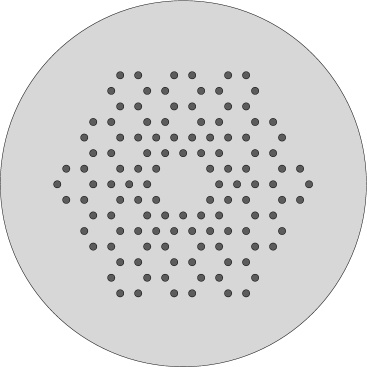

In [16]:
from IPython.display import Image
Image(filename='pattern_fiber.png') 

This fiber is encoded in a similar way to (b), but the pattern seen is created by passing a list that determines which tubes are removed.  Here we describe how to create that list.  

First, we setup some rules for navigation.  We assume the origin is at the center of the fiber and orthogonal x and y axes are centered at that origin with x pointing due east, (hence falling along one vertex of the underlying hexagon).  We then say that the layers are indexed starting at 0 with a single tube at the origin, followed by a layer (at distance $\Lambda$) at index 1 consisting of a hexagon of six tubes, followed by a layer at index 2 of 12 tubes, etc.  We order the tubes in a given layer counter-clockwise starting with the tube at the vertex intersecting the x-axis.  

Note that in the above geometry we have the same number of layers and core size as in geometery (b) namely 6 layers of tubes and 2 layers skipped to make the core.  The first two layers of tubes are complete, but the remaining layers have some missing.  To encode the first two layers, we set-up a list like this:


In [26]:
pattern = [[1,1,1,1,1,1,1,1,1,1,1,1],
           [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]]

The list has as first entry a list consisting of 12 ones, one for each of the tubes in the first (non-core) layer of tubes that is present.  The second entry is a list of 18 ones, a one for each tube that appears in the second (non-core) layer of tubes.  So far, only 1's have appeared since no tube has been missing.

For the next layer we begin at the tube intersecting the x axis and go counter-clockwise.  The first tube appears, so that gives a 1, as does the second, another 1, while the third is missing, so we put a 0.  It then continues with three 1's, then a 0, then three more 1's, etc.  Thus we append the following:

In [27]:
l3 = [1,1,0,1,
      1,1,0,1,
      1,1,0,1,
      1,1,0,1,
      1,1,0,1,
      1,1,0,1]
pattern.append(l3)
pattern

[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1]]

We continue in this way for the remaining three layers:

In [28]:
l4 = [1,0,1,1,0,
      1,0,1,1,0,
      1,0,1,1,0,
      1,0,1,1,0,
      1,0,1,1,0,
      1,0,1,1,0]

l5 = [0,1,1,0,1,1,
      0,1,1,0,1,1,
      0,1,1,0,1,1,
      0,1,1,0,1,1,
      0,1,1,0,1,1,
      0,1,1,0,1,1]

l6 = [1,1,0,1,1,0,1,
      1,1,0,1,1,0,1,
      1,1,0,1,1,0,1,
      1,1,0,1,1,0,1,
      1,1,0,1,1,0,1,
      1,1,0,1,1,0,1]
pattern.append(l4)
pattern.append(l5)
pattern.append(l6)

Since everything about this fiber is the same as (b) in the first case, we can use the parameters from (b) but change the "pattern" attribute from the empty list to our new list:

In [32]:
params['pattern'] = pattern

In [33]:
C = PBG(params)

ModeSolver: Checking if mesh has required regions


In [34]:
ng.Draw(C.mesh)

# References

1) Murao, Tadashi & Saitoh, Kunimasa & Koshiba, Masanori. (2011). Multiple resonant coupling mechanism for suppression of higher-order modes in all-solid photonic bandgap fibers with heterostructured cladding. Optics express. 19. 1713-27. 10.1364/OE.19.001713. 